In [1]:
import pandas as pd
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from copy import deepcopy

file = r".\train-images.idx3-ubyte"
arr = idx2numpy.convert_from_file(file)#simple import (took me half an hour)


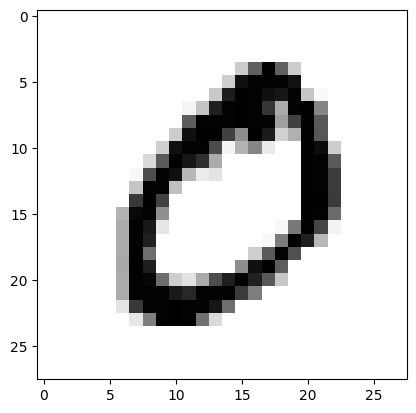

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253
  159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252
  252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239
  233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202
   84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 25

In [2]:
plt.imshow(arr[1], cmap=plt.cm.binary)
plt.show()
print(arr[1])

In [3]:
class Network(): #refer to the "documentation" buried within my notes
                #vectorized implementation of a basic neural networks
                #TODO add support for other cost functions/activaiton functions
                #TODO add support for deleting layers
    class Layer():

        def __init__(self,nodeCount,nodePreviousLayer=0):#keep node connections as an array for better performance(to avoid member access overhead)
            
            print("debug:")
            print(nodePreviousLayer)

            self._nodeArray = np.zeros(nodeCount,float)#node array

            if(nodePreviousLayer):

                self._weightArray = np.ones([nodeCount,len(nodePreviousLayer._nodeArray)],float)#incoming weights array row = node to go in, column = weights of the node in
                self._biasArray = np.ones(nodeCount)#bias array

                self._dBiasArray = np.zeros(nodeCount,float)#derivative of bias
                self._dWeightArray = np.zeros([nodeCount, len(nodePreviousLayer._nodeArray)], float)  # derivative of incoming weights
                self._dNodeArray = np.zeros(nodeCount,float)#delta array of ∂Activation/∂Node (refer to documentation)
                                                            #node = w*incoming + bias

                self._prevNodeArray = nodePreviousLayer._nodeArray #array of previous layer's data #DANGER MAKE SURE IT IS PASSING BY REFERENCE
                

        def _forwardProp(self): #TODO change this to support other activation functions
            self._nodeArray = np.matmul(self._weightArray,self._prevNodeArray)+self._biasArray
            # self._nodeArray = expit(self._nodeArray)
            
        # def _backProp(self):
            
    _layers = []

    def __init__(self, startCount):#start count initializes the first layer
        print("hi")
        self._layers = []
        self._layers.append(self.Layer(startCount))

    def addLayer(self,nodeCount):#public interface to add new layers (not counting the starting layer)
        self._layers.append(self.Layer(nodeCount,self._layers[-1]))
        print("current layer count = ")
        print(Network._layers)

    def setInputLayer(self,inputData):#public interface to set first layer data
        self._layers[0]._nodeArray = inputData.copy() #better be safe than sorry

    def trainNetwork(self):
        for i in range(len(self._layers)-1):
            self._layers[i+1]._forwardProp()

    def getResult(self, desiredAnswerNodes):#calculate the cost
        outputNodes=self._layers[-1]._nodeArray
        print("output nodes: " , outputNodes)
        return self._costFunction(desiredAnswerNodes,outputNodes)
    
    def _costFunction(self, desired,output):#cost function, Mean squared error
        return np.sum(np.power(desired - output,2))


In [6]:
network = Network(5)
network.setInputLayer([1,1,1,1,1])
network.addLayer(2)
network.addLayer(2)
network.addLayer(3)
network.addLayer(4)
print(network.getResult([1, 1,1,1]))
network.trainNetwork()   
network.trainNetwork()
network.trainNetwork()
network.trainNetwork()
print(network.getResult([1,1,1,1]))

hi
debug:
0


debug:
current layer count = 
[]
debug:
current layer count = 
[]
debug:
current layer count = 
[]
debug:
current layer count = 
[]
output nodes:  [0. 0. 0. 0.]
4.0
output nodes:  [1. 1. 1. 1.]
0.0


In [5]:
testA = np.array([[1,2],
                  [3,4]])
testB = np.array([[1,1,1]])
testC = np.ones((3,2))
print(np.matmul(testA,testB))
print(testC)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)